<a href="https://colab.research.google.com/github/musandur/ML-Projects/blob/main/Project2_Interpretabily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> > > **Towards Explanability-based defense techniques**

> > > > > >**Introduction**

In this work, I would like to introduce a new idea towards building a more sophisticated model in terms of robustness. For that, I need to combine model explainability techniques and counterfactuals explanations to generate adversarial images. That is, for a given image, I systematically use aggregate of superpixels to generate an adversarial example, rather than perturbing all pixels at once. Indeed, standard adversarial examples are just counterfactuals called by different names. Moreover, I find that adversarial images built from counterfactual explanations are more realistic in terms of real world applications. Another benefit of this approach is that we may not need to solve heavy optimization problem to get them. In fact, we only need to rely on image-based model explanations.
This sounds intuitively fair, since  potentially dangerous adversaries may be constructed after an explanation of a model is known. Indeed, within explanations lies limitations of understandings. Hence, these limitations may dangerously be exploited to attack the model. Note that I intend to restrict this study solely to image classification models. Moreover, I would like to push forward the idea that adversarial examples are actually features that are intrinsique to the image itself. That is, I want to find an easy way to retrain the standard ML model to focus only on essential features, given an input image. This will then lead us to achieve robustness. \\
The reason why I want to consider this family of perturbed images built from counterfactuals is to help the machine intelligence inherits some human visual abilities and, hopefully, be naturally robust against attacks. Indeed, once a human sees an information, he or she can ultimately recognize that information, even if some of its parts are hidden or removed. But, based on number of adversarial examples shown in the ML community, it turns out that the machine learning models may not succeed to develop the same visual skill. Another reason for considering this family of attacks is to go beyond the standard rule that consists of defining an adversrial image as being visually identical to the clean image. Indeed, real world images are often covered by crafted stickers, or graffiti, etc. 

Known attacks, such as C&W, are modeled to yield a minimal perturbation of an image which results in a misclassification of the perturbed image, despite the fact that the original image and its perturbed version are undistinguishable in humans eyes. However, in the physical world, attacks may be more radical than that. Examples include the presence of stickers on a stop sign, sun glass on the face of a human being. As a consequence, these radical attacks may, for example, cause an autonomous vehicle relying on vision to crash by manipulating the perceived image of a road sign, such as the stop sign. Thus, the complex nature of real world attacks may be able to defy any implemented defense algorithm. This is a huge obstacle to industrial artificial intelligence, in general, and has installed a Tom and Jerry battle between attacks and defenses algorithms. Therefore, in this work, I would like contribute to building a defense technique based on attacks that are similar to real world adversaries. 
The benefit of this new idea is to hit two targets with one rock. That is, an image-based local model explanation is yielded and, eventually, used to build robustness. 

The state-of-the-art proposed algorithms for ML classifiers explainability, such as LIME (see Rabiro et al.), have proved themselves to be mostly reliable for solving the laymen trust issues on ML models when making decisions which are based on these ML predictions. Technically, the LIME idea is mainly based on seeking the most relevant aggregation of superpixels that is closest, in the sense of similarity, to the underlying original input data. For that, a set of finite coefficients of an explainable linear regression model, which is learned on perurbed instances, is used to approximate locally the complex black box model, and each coefficient measures the potential of a corresponding superpixel (perturbed instance) to represent a visually meaningful piece of the original image. It is, thus, obvious that selecting all the coefficients yields the concatenation of all superpixels and, hence, the original image. Furthermore, in terms of explanation, some superpixels are more visually relevant than others. This is formalized numerically in terms of coefficient magnitudes of the regression model. Therefore, for explaining the correct prediction of a given image, one arbitrarily selects $k$ first largest magnitude coefficients and displays  the aggregation of their corresponding superpixels. In this way, the resulting image is highly similar to the original image and, hence, a user is convenced by the ML model's prediction. 
However, does the same ML model predicts the same true label for that resulting perturbed image, despite its similarity to the original image? 
The immediate answer to this question is neither yes nor no! Actually, it always depends on a couple of things: the number of coefficient being used, the original image itself, and the robustness of the ML model being used. We do, however, know that if all coefficients are selected, the answer is yes, since it is obvious that the resulting image and the original image are exactly the same. 
Note that, as a mentioned above, the number of superpixels(perturbed instances) to be picked for explaining a correct prediction is arbitrary, which is not a problem when only a model explanation is required. 

In this study, I would like to focus on a varying number $k$ of superpixels for systematically generating image-based conterfactual explanations including adversarial examples. That means, I first seek a critical number $\bar{k}$ above which all perturbed images are correctly predicted with the same class as the original image, and below which all perturbed images are wrongly predicted with a class different from the original image. But, these wrongly predicted images would probably be correctly predicted by humans, as they are still similar to the original image minus some hidden pieces; they are just some different parts of the original image. That is, one may understand the parameter $\bar{k}$ as instanciating the closest world possible to obtain a different a label. Second, I wish to build a strong defense that can mitigate these adversarial threats.

Finally, note that this is an idea I am willing to discuss and pushforward towards a successfully polished piece of work. Hence, as any scientific idea, it may work or may not.  



> > > **LIME (Local Interpretable Model-agnostic Explanations): detailed review**

In the following, I briefly explain the LIME method for explaining the prediction of a deep neural network model for image classification. I will use the pretrained model called *Inception version 3*, which is trained on the Imagenet dataset by google developpers. More precisely, we are going to show how the prediction of a selected image can be explained without having access to the black box model. 

In [ ]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import sklearn
import sklearn.metrics
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.preprocessing.image import load_img
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
import copy
from sklearn.linear_model import LinearRegression


from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input

#----Authorise and mount my Google drive---#
from google.colab import drive
drive.mount('/content/drive')

#-----Unzip my dataset from GC (Google Colab)----'
!unzip -uq "/content/drive/MyDrive/adversarial_images.zip" -d "/content/drive/MyDrive/"

np.random.seed(222)



Mounted at /content/drive
unzip:  cannot find or open /content/drive/MyDrive/adversarial_images.zip, /content/drive/MyDrive/adversarial_images.zip.zip or /content/drive/MyDrive/adversarial_images.zip.ZIP.


The image below is a dog, more precisely, a Rottweiler. Hence, using our pretrained neural network, we will use this image as the original input image. 

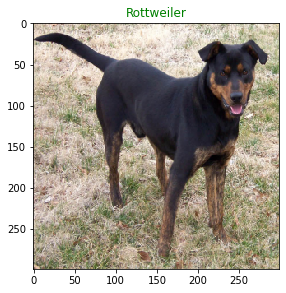

In [ ]:
Xi = skimage.io.imread('/content/drive/MyDrive/adversarial_images/dog.jpg')
#Xi = tf.cast(Xi, tf.float32)
Xi = skimage.transform.resize(Xi, (299,299)) 
skimage.io.imshow(Xi)
plt.title('Rottweiler', color='green')
plt.show()




In [ ]:
the_inception_model = keras.applications.inception_v3.InceptionV3()

In [ ]:
preds = the_inception_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes


[('n02106550', 'Rottweiler', 0.312598),
 ('n02101006', 'Gordon_setter', 0.051661253),
 ('n02105412', 'kelpie', 0.050224792),
 ('n02089078', 'black-and-tan_coonhound', 0.039947852),
 ('n02107142', 'Doberman', 0.03614275)]

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
print(top_pred_classes)                #Index of top 5 classes


[234 214 227 165 236]


Now, after having dowloaded the inception model above and correctly predicted our input image, we  begin our firts step towards providing **prediction and explanation**. That is, having the original image, we generate partition of this image into **superpixels**. Indeed, these superpixels are going to be the building blocks for explaining the underlying model's prediction.

64


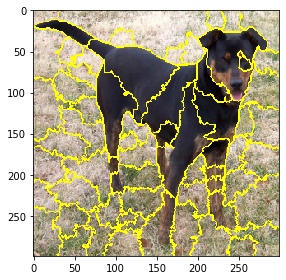

In [ ]:
# Generate the superpixels 
segments_quick = quickshift(Xi, kernel_size=4, max_dist=200, ratio=.2)
skimage.io.imshow(mark_boundaries(Xi, segments_quick))
num_superpixels = np.unique(segments_quick).shape[0]
print(num_superpixels)

We have generated 64 superpixels thanks to the quickshift segmentation algorithm, which means that the input image is partitioned into 64 sub-images. Note that it is important to choose sub-images that are explainable from human eye. 

Next, we generate 150 vectors of length the number of superpixels and whose entries are obtained from a Bernouli distribution . That means, each vector is a sequence of randomly generated 0 and 1 entries. In fact, each  causes its corresponding superpixel to be **on** or **off**. That is why, the length of each vector is the same as the number of superpixels. As a consequence, a superpixel is eliminated from the image when its corresponding entry in the vector is 0. Since each vector is randomly generated, then we have 150 randomly perturbed versions of the original image. 

In [ ]:
# Creating the random perturbations of the underlying image
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
print(perturbations.shape)
print(perturbations[0]) #Show example of perturbation

(150, 64)
[1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0]


Thus, we write a function that pertubes an original image. The function is then tested and, as an example, we have the perturbed image below. One is able to recognize our dog, even though some superpixels are randomly removed from the original image. This is quite similar to pouring a dark fluid on a stop sign, for instance. Hence, an eventually legitimate question may be: **will the AI model still predict this perturbed image as the same label as the original image (i.e. Rottweiler)**

(299, 299, 3)


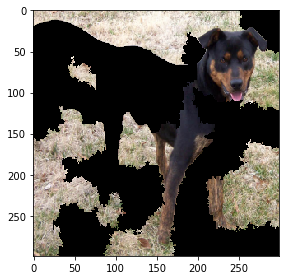

In [ ]:
# Function that perturb the given image based on a perturbation vector

def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

  # One perturbation example 

skimage.io.imshow(perturb_image(Xi,perturbations[0],segments_quick))
yy = perturb_image(Xi,perturbations[12],segments_quick)
print(yy.shape)

In order to locally approximate the black box model with an explainable model and explain the model's prediction, we are going to need more data with which the explainable model will be built. Hence, predictions of perturbed images are ultimately needed. That is why, in the code below, predictions of the perturbed images are made and the resulting labels are collected for later use.

In [ ]:
# Predicting the different perturbed images
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,segments_quick)
  pred = the_inception_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

Now, we measure similarities between the perturbed images and the original image being explained. We actually need these measures in order to systematically select the **best aggregates of superpixels** that are closer to the original image being explained, in terms of similarity. For that, we first compute distances between a full vector of ones and the random vectors. Indeed, recall that each random vector represents an aggregation of superpixels. Hence, these (cosine) distances measure the difference between the vector representing the original image and the random vectors of perturbed images. However, the most important measures are the **weights**, which are kernel functions that measure the **similarity between the perturbed images and the original image** being explained. The weights are computed using the distance measures. 

In [ ]:
# computing distances between the original image and the perturbed images
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

# Computing the corresponding weights
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

Using the random vectors, the predictions of the perturbed images and the weights, we fit a **linear regression model** to these data. Note that the weights are measures that determine how much each observation (i.e. random vectors) in the dataset influences the final prediction. Besides, there is a **one-to-one correspondence between each coefficient in the linear regression and each superpixel**. Hence, the magnitude of these coefficients can be understood as how relevant each superpixel is for predicting the *Rottweiler*. 

In [ ]:
# fit the perturbed data with the linear reg model

from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff
print(len(coeff))

64


Therefore, we sort the coefficients in order to find the superpixels for the largest coefficient. In the code below, I pick the one biggest coefficient and display its corresponding superpixel. As a result, we have an image that explains **why the underlying neural network model predicted a *Rottweiler***. The ouput is visually convincing. Indeed, comparing the original image and the image obtained from the explainable model, anyone would give credit to the internal setting of the underlying black box model with respect to the prediction of the *Rottweiler*. Note that we can always change the number of coefficients used to display the image-based explanation. In this specific case, only one coefficient is enough, as it would correspond to the head of the dog being explained; head says it all! 

[8]


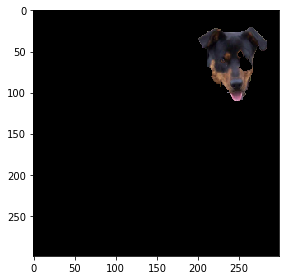

In [ ]:
#  Now we sort the coefficients to figure out the superpixels with largest coefficients and ...
#Here we show the most important superpixels 


num_top_features = 1

top_features = np.argsort(coeff)[-num_top_features:] 
print(top_features)

mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi,mask,segments_quick) )



In the following, of interest is all the coefficients of the linear model. Hence, we collect them in 
$$\mathcal{C} = \{c_1, c_2,\cdots, c_k, \cdots, c_N\}$$
where N=64 and $c_1\geq c_2\geq\cdots c_N$. The **defense technique** we want to build will make use of all these coefficients to generate superpixels and create perturbed data for retraining purpose. 

  > > >**Generate counterfactual explanations as adversarial examples**

Note that the number of superpixels to be picked for explaining a correct prediction is arbitrary, which is not a problem when only a model explanation is required as above. However, in this study, I would like to focus on varying $k$ for finding a critical parameter for generating counterfactuals considered as adversarial images. That means, I seek a critical number $\bar{k}$ above which all perturbed images are correctly predicted with the same class as the original image, and below which all perturbed images are wrongly predicted with a class different from the original image. But these wrongly predicted images would probably be correctly predicted by any conscious human being, as they are still similar to the original image minus some hidden pieces. This is visually illustrated below.


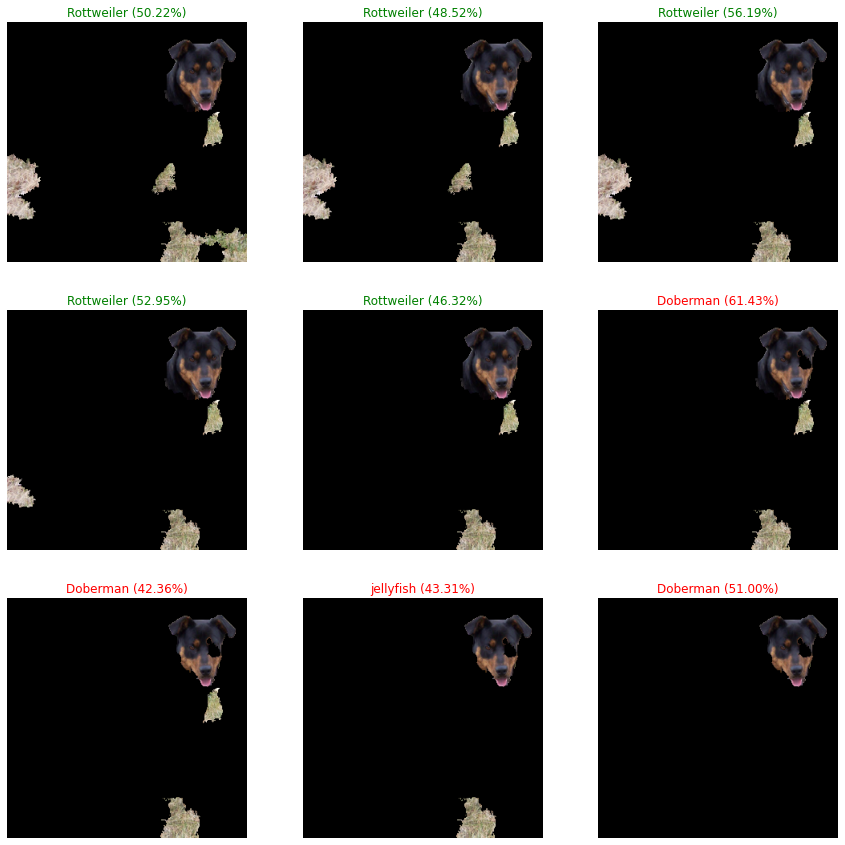

In [ ]:
num_perturbed =9
n_col = 3
n_row = (num_perturbed + n_col - 1) / n_col
plt.figure(figsize=(15, 15))

for num_top_features in range(1, num_perturbed+1)[::-1]:
  top_features = np.argsort(coeff)[-num_top_features:]
  #print(top_features)

  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels
  ##skimage.io.imshow(perturb_image(Xi,mask,segments_quick) )


  # now we are going to look at the predictions of the perturbed images via lime
  Xi_p = perturb_image(Xi,mask,segments_quick)
  preds = the_inception_model.predict(Xi_p[np.newaxis,:,:,:])
  yy = decode_predictions(preds)[0] #Top 5 classes
  ttl1 = yy[0][1]
  ttl2 = yy[0][2]*100
  ##print('%s (%.2f%%)'%(yy[0][1], ttl2))

  decode_predictions(preds)[0] #Top 5 classes

  #plt.figure(figsize=(25, 25))
  plt.subplot(n_row, n_col, 1+num_perturbed -num_top_features)
  plt.imshow(perturb_image(Xi,mask,segments_quick))
  plt.axis('off')
  if ttl1=='Rottweiler':
    plt.title('%s (%.2f%%)'%(ttl1, ttl2), color='green')
  else: 
    plt.title('%s (%.2f%%)'%(ttl1, ttl2), color='red')

  #ax[0, 0].set_title('Compact watershed')



In the figures above, we have displayed explained images using 9 largest coefficients of the explainable model in the following way:
in panel 1, we use all the 9 coefficients to aggregate the corresponding superpixels, \\
in panel 2 we have removed the smallest coefficient among the 9 and use the 8 remaining coefficients to aggregate their corresponding superpixels, and so on... \\
Hence, the last panel uses the single largest coefficient and displays its corresponding superpixel. Recall that, this superpixel is closest to the image being explained in terms of similarity. That is why, we decided that such a superpixel, which we refer to as the **dominant or superpixel**, should be present in all the other images under consideration. In fact this superpixel is critical in the sense that it makes the image adversarial images credible. That means, any aggregation of superpixels without the dominant (or essential) superpixel would yield an image that will not make sense to human eye. In this specific example, the essential superpixel corresponds to the **head of the rottweiler**, which really makes sense. Indeed, **the head is critical** in recognizing any living being.

As we can see, varying the number of coefficients for displaying image-based explanations of the model's prediction yields images that may or may not be classified back to the same label (*Rottweiler*) by the underlying black box model. Besides, here, $\bar{k} = 6$ is the critical parameter that determines **the closest possible world possible to arrive at a misclassification**. Beyond $\bar{k}$, all images are misclassified by the model, but a human being would not do this mistake, given the presence of the essential superpixel in each image. Therefore, the **misclassified images** are **credible to  be called adversarial examples**. 
For example, with a standard adversarial perturbation technique (example includes the fast gradient sign method), some may be surprised to see an imperceptibly perturbed version of the **Rottweiler** be classified as a **jellyfish** or a **Dobermann**.  But here, I think it can be comprehended because of the presence of the yellowish grass in a jellyfish-like shaped superpixel (see 8th panel above). The prediction of **Dobermann**  is also surprising despite the striking resemblance that may exist between a Rottweiler and a Dobermann. Indeed, **after having seen the Rottweiler, no conscious human being would predict this counterfactual as a Dobermann**. 

Now, a critical question may be the following: \\
**Given the presence of both a Jellyfish-like shaped superpixel and the head of the *Rottweiler* in one image, why did the black box model choose to favor the Jellyfish shape instead of the Rottweiler head ?** \\
All I can say, for now, is that more **significant weights** were internally assigned to the jellyfish-like shape, and this has resulted in classifying the image as a jellyfish. That may actually be the effect of almost all adversarial perturbations: **some superpixels are internally given more weights** than the others and, hence, output predictions are made, based on the resulting features.

**Hence, should one expect to see Dobermann and Jellyfish to figure in the list of the labels that (untargeted) adversarially perturbed versions of our original image are classified to by the underlying deep learning model** ? \\
All I can say, for now, is that the **cause of these misclassifications** can be **visually justified** just by looking at the superpixels that compose each perturbed image above. Therefore, in the following, I am going to use an untargeted standard perturbation in order to prove whether or not an unperceptibly perturbed version of our original image will yield Doberman or a Jellyfish. I will use the single-step **fast gradient sign method** (FGSM) by I. Goodfellow, (2014). the FGSM is a single-step classical method of generating an adversarial input image. It is a gradient-based method in the sense that the optimal perturbation is a function, the **gradient of the loss function** with respect to the variable $x$. That is, attacks are generated by using the equation
$$\tilde{x} = x + \epsilon \text{sign}\big(\nabla_x L(\theta, x, y)\big)$$
where $x$ is the unperturbed input image with its true class $y$, $\epsilon$ is the size (or amplitude) of the perturbation, $L(\theta, x, y)$ is the loss function used to train the model, and $\tilde{x}$ is the perturbed image. 
Note that in order to have $\tilde{x}$, the loss function should be considered to be only a function of $x$. That means, the learned parameters $\theta$ must be frozen. Indeed, one should know that the CNN model has already been successfully trained and, thus, the critical parameters were obtained using (stochastic) gradient descent algorithm, for instance. Now that the loss function is only a function of $x$, the sign its gradient with respect to $x$ yields always the direction of the steepest ascent of the graph $\big(x, L(\theta, x, y)\big)$. That means, when the noise $\epsilon \text{sign}\big(\nabla_x L(\theta, x, y)\big)$ is added to $x$, the function $L(\theta, \tilde{x}, y)$ moves up towards its maximum, in a **single step**. Therefore, $\tilde{x}$ tends to maximize the loss function with respect to the true class. As a matter of fact, the FGSM seeks to alter the image in order to discredit the classifier by increasing its classification error at $\tilde{x}$ and, thus, causes the CNN model to predict a label $y^{\prime}\neq y$ instead of $y$.






In [ ]:
import tensorflow as tf


This function takes as input the image and its true label, then computes the sign of the gradient of the loss function with respect to the image.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def Gradient_Sign_Pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = the_inception_model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  signed_gradient = tf.sign(gradient)
  return signed_gradient
  

Now, we visualized the resulting perturbation, which is just the sign of the gradient computed above.

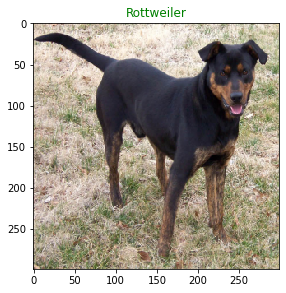

In [ ]:
Yi = skimage.io.imread('/content/drive/MyDrive/adversarial_images/dog.jpg')
#Yi = tf.cast(Yi, tf.float32)
Yi = skimage.transform.resize(Yi, (299,299)) 
skimage.io.imshow(Yi)
plt.title('Rottweiler', color='green')
plt.show()

Yi = tf.cast(Yi, tf.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


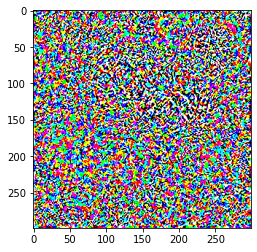

In [ ]:
image_index = top_pred_classes[0]
image_label = tf.one_hot(image_index, preds.shape[-1])
image_label = tf.reshape(image_label, (1, preds.shape[-1]))

perturbations = Gradient_Sign_Pattern(Yi[None,...], image_label)
plt.imshow(perturbations[0])
plt.show()

Now, we perturb images with the gradient sign displayed above and predict the perturbed versions using the inception_v3 model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


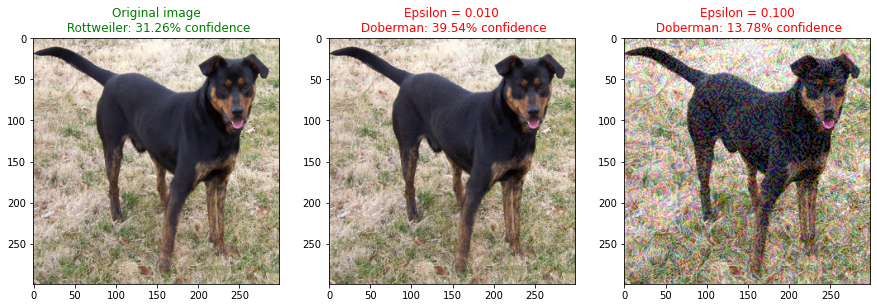

In [ ]:
def get_image_label(preds):
  # this function returns the 
  # predicted class with highest probability
  return decode_predictions(preds)[0][0]

epsilons = [0, 0.01, 0.1]
n_col = 3
n_row = (len(epsilons) + n_col - 1) / n_col
plt.figure(figsize=(15, 15))

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Original image') for eps in epsilons]
for i, eps in enumerate(epsilons):
  adv_x = Yi + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  _, label, confidence = get_image_label(the_inception_model.predict(adv_x))
  plt.subplot(n_row, n_col, i+1)
  plt.imshow(adv_x[0])
  if label == 'Rottweiler':
    plt.title('{}\n {}: {:.2f}% confidence'.format(descriptions[i], label, confidence*100), color='green')
  else:
    plt.title('{}\n {}: {:.2f}% confidence'.format(descriptions[i], label, confidence*100), color='red')

plt.show()


Similar to the previously displayed perturbed images, a green colored title is equivalent to a correct prediction, while a red colored title means a misclassification. \\
In the pictures above, the **first panel is the unperturbed image** and, as a consequence, it is correctly classified as such. However, the **second and third panels are the adversarially perturbed** versions of the clean image. As a consequnece, both of them are able to **fool the deep learning model** (here, the inception_v3)  and are classified as **Dobermann**. This is to say that the FGSM has confirmed, in this specific example, that our **superpixel-based perturbation is credible** to be **considered as a standard adversarial perturbation**. Moreover, as mentioned above, our superpixel-based perturbation is more credible to model real world perturbation scenarios.

That is why, I believe that, in terms of physical world adversarial examples, **counterfactual adversaries**, as I formulate it here, seem to be very powerfull and adapted to real world scenarios. \\

Therefore, in order to make a black box model robust, one may proceed with an adversarial training where clean images and counterfactuals images are both considered. That, the unperturbed deep learning model is retrained **to only focus on the essential superpixel**, which correspond here to the head of Rottweiler. In the next section, we are going to formulate how that should be done.

> > > **Defense algorithms: adversarial retraining with neural structured lerning**

For the moment, I suggest an adversarial retraining as a defense algorithm. I hope that the more this idea will be sharpened, a new defense technique may be found.






The **loss function of the adversarial training** is formally given by
$$loss = \sum_{i=1}^{N} L(y_i, \hat{y}_i) + \lambda \sum_{i=1}^N L_{\mathcal{N}}(y_i, x_i, \mathcal{N}(x_i))$$ 

where $y_i$ is the true label of $x_i$ (ground truth) and $\hat{y}_i$ is the predicted label by the classifier $f$. Thus, the first term $\sum_{i=1}^{N} L(y_i, \hat{y}_i)$ of the loss function $loss$ is just the supervised loss associated with the model (i.e. the loss function of the original classifier $f$). 
The second term $\sum_{i=1}^N L_{\mathcal{N}}(y_i, x_i, \mathcal{N}(x_i))$ is referred to as the **neighbor loss**, as it computes the **distance between $x_i$ and its adversarially perturbed versions**. Indeed, $\mathcal{N}(x_i)$ yields the set of **neighbors of $x_i$**. These are the data points that share significant similarities with $x_i$. In the context of this work, $\mathcal{N}(x_i)$ **is just the set of counterfactual images** displayed above. Note that a rigourous retraining should only consider counterfactual images that are misclassified. Hovewer, given that a training dataset have more than one sample, it is not clear that the number of misclassified counterfactual images in one sample is the same in another sample. Hence, I would suggest to equilibrate the number of counterfactual images to be the same in each sample. That would certainly include correctly classified counterfactual samples, but hopefully, this will not impact the result.
 
 In more details, thus, $L_{\mathcal{N}}(y_i, x_i, \mathcal{N}(x_i))$ can be written as 
$$L_{\mathcal{N}}(y_i, x_i, \mathcal{N}(x_i)) = \sum_{x_j \in \mathcal{N}(x_i) } w_{ij}\cdot \mathcal{D}(h(x_i), h(x_j))$$ 
where $h(\cdot)$  yields the distribution of features within the underlying hidden layer before the softmax layer. $\mathcal{D}$ is a distance metric, say Euclidian $\ell_2$ metric. $w_{ij}$ measures how strong the connection between $x_i$ and $ x_j$ is; it can be thought of as a **weight between two nodes in a graph**. Note that the $x_j$'s in $\mathcal{N}(x_i)$ are just the selected counterfactual images. Thus, the neighbor loss of the adversarial training seeks to measure differences between the distribution of features generated by $x_i$ and the distributions of features generated by its neighbors $\mathcal{N}(x_i)$ within a hidden layer. As a matter of fact, by **minimizing**  $\sum_{i=1}^N L_{\mathcal{N}}(y_i, x_i, \mathcal{N}(x_i))$ we mean that we want to **constrain the CNN model** to view and encode $x_i$ (the Rottweiler, for instance) and its **neighbors (or counterfactuals), as being the same thing** whatsoever. In this way, the clean image and its counterfactuals will all be classified as the same label (a Rottweiler, for instance). Given the training dataset, this process will be done for samples. Hence, we will hopefully achieve robustness. 

Note that the implementation requires to include in the retraining code sample the LIME API. That is, the code should generate, on the fly, the requested counterfactual images. I also expect the runtime to not be fast, but I have decided to benchmark it first and then refine later.

To be continued...

As I mentioned in the introdiction, this is just an early idea under refinement, and there may be 
plenty of questions already. I am not sure if this idea is right, obvious or wrong, but the aim is to end up with a scientific product that will be useful for the AI community.

I am also willing to discuss it  before going too far...